In [1]:
import effdet, zipfile, json
import torch, os, cv2, random
from PIL import Image
import numpy as np
import kornia as K
from ensemble_boxes import ensemble_boxes_wbf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import fastprogress

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
model_path = '/home/ubuntu/models/det/rcnn/model.pth'
conf_path = '/home/ubuntu/models/det/rcnn/config.json'
img_path = '/mnt/data/circuits/images'

In [3]:
import os
import mimetypes
from pathlib import Path
from functools import partial

get_ext = lambda x: [i for i,j in mimetypes.types_map.items() if j.startswith(x)]

image_ext = get_ext('image')
video_ext = get_ext('video')
text_ext = get_ext('video')
audio_ext = get_ext('audio')

join_path = lambda x,y: Path(os.path.join(x, y))

def get_files(root, file_type=None, recursive=True):
    files = []
    if file_type: file_type = tuple(file_type)
    if not recursive:
        files.extend([join_path(root, i) for i in os.listdir(root) if str(i).lower().endswith(file_type)])
    else:
        for p, d, fs in os.walk(root):
            if file_type:
                files.extend([join_path(p, f) for f in fs if str(f).lower().endswith(file_type)])
            else:
                files.extend([join_path(p, f) for f in fs])
    return files

get_image_files = partial(get_files, file_type = image_ext)
get_video_files = partial(get_files, file_type = video_ext)
get_text_files = partial(get_files, file_type = text_ext)
get_audio_files = partial(get_files, file_type = audio_ext)

In [4]:
def _noop_normalize(image):
    return image

def _noop_resize(image, target):
    return image, target

def remove_internal_model_transforms(model):
    model.transform.normalize = _noop_normalize
    model.transform.resize = _noop_resize
    
def get_faster_rcnn(nc):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nc)
    remove_internal_model_transforms(model)
    return model

In [8]:
def normalize(o):
    return K.normalize(o/255.0,
                        mean=torch.tensor((0.485, 0.456, 0.406)),
                        std=torch.tensor((0.229, 0.224, 0.225)))

In [9]:
class ImageDataset(Dataset):
    def __init__(self, fs, img_sz):
        self.fs = fs
        self.img_sz = img_sz
    
    def __getitem__(self, idx):
        img = Image.open(self.fs[idx]).convert('RGB')
        w,h = img.size
        img = np.array(img.resize((self.img_sz, self.img_sz)))
        return torch.from_numpy(img).permute(2, 0, 1), torch.tensor([w, h]), self.fs[idx].stem
    
    def __len__(self): return len(self.fs)

In [18]:
class RCNNPredict:
    def __init__(self, model_path, conf_path):
        self.load_conf(conf_path)
        self.model = self.load_model(model_path)
        self.prediction_thres = 0.5
        self.img_sz = self.conf['img_sz']
        self.enc = {i:j for i,j in enumerate(self.conf['classes'])}
        self.f_enc = lambda x: self.enc[x]
        
    def load_model(self, o):
        m = get_faster_rcnn(len(self.conf['classes']))
        m.load_state_dict(torch.load(o))
        m = m.float()
        m = m.eval()
        m = m.cuda()
        return m
    
    def load_conf(self, p):
        with open(p, 'r') as f:
            self.conf = json.load(f)
            
    def rescale_bbox(self, bbox, w_scale, h_scale):
        bbox = np.array(bbox)
        if len(bbox.shape) == 1: return bbox.tolist()
        bbox = bbox * [w_scale, h_scale, w_scale, h_scale]
        return bbox.tolist()
    
    def single_predict(self, p):
        img = Image.open(p).convert('RGB')
        w,h = img.size
        img = img.resize((self.img_sz, self.img_sz))
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).cuda().unsqueeze(0)
        bbox, conf, classes = self.single_pass(img)
        bbox = self.rescale_bbox(bbox, w/self.img_sz, h/self.img_sz)
        return bbox, conf, classes
    
    def single_pass(self, xb):
        with torch.no_grad():
            pred = self.model(self.normalize(xb))[0]
        bbox, conf, classes = tuple(map(lambda x: x.detach().cpu().numpy(), [pred['boxes'], pred['scores'], pred['labels']]))
        if len(classes) != 0 or not isinstance(classes, int): classes = list(map(self.f_enc, classes))
        return bbox, conf, classes
    
    def normalize(self, o):
        return K.normalize(o/255.0,
                         mean=torch.tensor((0.485, 0.456, 0.406)),
                         std=torch.tensor((0.229, 0.224, 0.225)))
    
    def post_proc_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(self.post_proc(detections[i]))
        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(predictions, image_size=512, iou_thr=0.2)
        return predicted_bboxes, predicted_class_confidences, predicted_class_labels
    
    def predict_dl(self, dl):
        pred_acc = dict()
        with torch.no_grad():
            for k, (xb, yb, name) in enumerate(dl):
                preds = self.model(list(self.normalize(xb.cuda())))
                temp = {n: {'bbox': self.rescale_bbox(p['boxes'].detach().cpu().numpy(), 
                                                      dims[0].item()/self.img_sz,
                                                      dims[1].item()/self.img_sz),
                            'conf': p['scores'].detach().cpu().numpy().tolist(),
                            'labels': list(map(self.f_enc, p['labels'].detach().cpu().numpy().tolist()))} for n, dims, p in 
                        zip(name, yb, preds)}
                pred_acc.update(temp)
        return pred_acc
    
    def dump_to_zip(self, detections, root='ob_pred.zip'):
        with zipfile.ZipFile(root, 'x') as z:
            for n, item in detections.items():
                if len(item['bbox']) == 0: continue
                with z.open(f'{n}.json', 'w') as c:
                    c.write(json.dumps(item, indent=2).encode('utf-8'))
    
    def predict_folder(self, path):
        fs = get_image_files(path)
        ds = ImageDataset(fs, img_sz = self.img_sz)
        dl = DataLoader(ds, batch_size=16, num_workers=2, pin_memory=True)
        predictions = self.predict_dl(dl)
        predict_path = 'ob_pred.zip'
        self.dump_to_zip(predictions, predict_path)
        return predict_path

In [19]:
m_predict = RCNNPredict(model_path, conf_path)

In [15]:
def plot_bboxes(img, bboxes):
    for box in bboxes:
        cv2.rectangle(img,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (220, 0, 0), 3)
    return img

/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


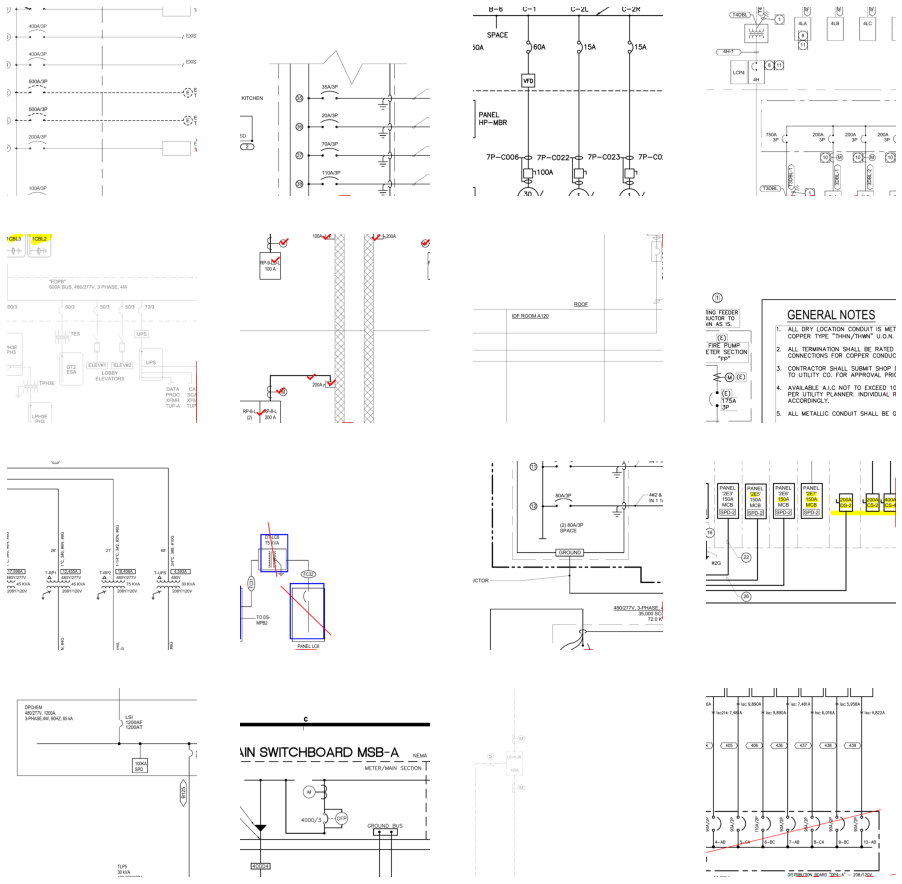

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for k, ax in enumerate(axes.ravel()):
    f = random.choice(fs)
    img = np.array(Image.open(f))
    bbox, conf, classes = m_predict.single_predict(f)
    img = plot_bboxes(img, bbox)
    ax.imshow(img)
    ax.axis('off')

In [21]:
predictions = m_predict.predict_folder('/mnt/data/circuits/images')

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
